In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import files
import io
import plotly.graph_objs as go
from plotly.offline import iplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import re
from math import isnan
import sklearn

device = "cpu"

In [ ]:
data_to_load = files.upload()

Saving data_file.csv to data_file (1).csv


In [ ]:
def remove_invalid_values_in_dataframe(df: pd.DataFrame) -> None:
    """
    функция убирает строки с невалидными значениями
    :param df: датафрейм
    :return: ничего не возвращает
    """
    deleted_counter = 0
    i = 0
    while i < len(df['date']):
        date = df.iloc[i]['date']
        value = df.iloc[i]['value']
        if date == 0 or date is None or isnan(value) or value <= 0 or value is None:
            df.drop(index=i + deleted_counter, inplace=True)
            i -= 1
            deleted_counter += 1
        else:
            if type(date) != str or re.match('\d{4}-\d\d-\d\d', date) is None:
                df.drop(index=i + deleted_counter, inplace=True)
                i -= 1
                deleted_counter += 1
        i += 1

In [ ]:
def read_csv_to_dataframe(file_name: str = 'data_file.csv') -> pd.DataFrame:
    """
    функция считывает данные из csv файла, устанавливает названия колонок и убирает невалидные значения
    :param file_name: название файла
    :return: возвращает датафрейм
    """
    df = pd.read_csv(file_name, sep=', ')
    columns_array = df.columns
    df.rename(columns={columns_array[0]: 'date', columns_array[1]: 'value'}, inplace=True)
    remove_invalid_values_in_dataframe(df)
    df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
    df = df.set_index(['date'])
    if not df.index.is_monotonic:
      df = df.sort_index()
    return df

In [ ]:
def plot_dataset(df: pd.DataFrame, title: str) -> None:
    """
    функция отрисовывает график
    :df: датафрейм
    :title: заголовок
    :return: ничего не возвращает
    """
    data = []
    
    value = go.Scatter(
        x=df.index,
        y=df.value,
        mode="lines",
        name="values",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Value", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)

In [ ]:
df = read_csv_to_dataframe(io.BytesIO(data_to_load['data_file.csv']))
print(df)
plot_dataset(df, title='ruble to dollar exchange rate(all time)')

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



              value
date               
1998-01-01   5.9600
1998-01-06   5.9630
1998-01-07   5.9690
1998-01-09   5.9720
1998-01-10   5.9740
...             ...
2022-10-11  62.3126
2022-10-12  63.6840
2022-10-13  63.7559
2022-10-14  63.4917
2022-10-15  63.0558

[6153 rows x 1 columns]


In [ ]:
def generate_time_lags(df: pd.DataFrame, n_lags: int) -> pd.DataFrame:
    """
    функция создаёт указанное кол-во столбцов для каждой даты, в которые помещаются предыдущие значения
    :param df: датафрейм
    :param n_lags: количество добавляемых столбцов
    :return: возвращает полученный датафрейм
    """
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["value"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

input_dim = 100

df_timelags = generate_time_lags(df, input_dim)
df_timelags

<ipython-input-111-82f19bf6fc56>:10: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,value,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag91,lag92,lag93,lag94,lag95,lag96,lag97,lag98,lag99,lag100
date,,,,,,,,,,,,,,,,,,,,,
1998-05-30,6.1640,6.1660,6.1620,6.1600,6.1580,6.1580,6.1575,6.1560,6.1550,6.1465,...,5.9975,5.9950,5.9900,5.9800,5.9760,5.9740,5.9720,5.9690,5.9630,5.9600
1998-06-02,6.1650,6.1640,6.1660,6.1620,6.1600,6.1580,6.1580,6.1575,6.1560,6.1550,...,6.0005,5.9975,5.9950,5.9900,5.9800,5.9760,5.9740,5.9720,5.9690,5.9630
1998-06-03,6.1660,6.1650,6.1640,6.1660,6.1620,6.1600,6.1580,6.1580,6.1575,6.1560,...,6.0010,6.0005,5.9975,5.9950,5.9900,5.9800,5.9760,5.9740,5.9720,5.9690
1998-06-04,6.1675,6.1660,6.1650,6.1640,6.1660,6.1620,6.1600,6.1580,6.1580,6.1575,...,6.0050,6.0010,6.0005,5.9975,5.9950,5.9900,5.9800,5.9760,5.9740,5.9720
1998-06-05,6.1685,6.1675,6.1660,6.1650,6.1640,6.1660,6.1620,6.1600,6.1580,6.1580,...,6.0150,6.0050,6.0010,6.0005,5.9975,5.9950,5.9900,5.9800,5.9760,5.9740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-11,62.3126,61.2475,60.2534,59.4043,58.7913,57.5664,55.2987,57.4130,58.4485,58.1756,...,61.5750,61.4733,61.6069,63.0975,66.4029,62.0495,56.2996,56.9690,58.2087,58.8862
2022-10-12,63.6840,62.3126,61.2475,60.2534,59.4043,58.7913,57.5664,55.2987,57.4130,58.4485,...,61.9659,61.5750,61.4733,61.6069,63.0975,66.4029,62.0495,56.2996,56.9690,58.2087
2022-10-13,63.7559,63.6840,62.3126,61.2475,60.2534,59.4043,58.7913,57.5664,55.2987,57.4130,...,61.1094,61.9659,61.5750,61.4733,61.6069,63.0975,66.4029,62.0495,56.2996,56.9690


In [ ]:
def feature_label_split(df: pd.DataFrame, target_col: str):
    """
    функция выделяет выбранный столбец из датафрейма
    :param df: датафрейм
    :param target_col: столбец, который необходимо выделить из датафрейма
    :return: возвращает столбец и оставшийся датафрейм без этого столбца
    """
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def train_val_test_split(df: pd.DataFrame, target_col: str, test_ratio: float) -> pd.DataFrame:
    """
    функция разделяет датафрейм на обучающую, тестовую и валидационную выборки
    :param df: датафрейм
    :param target_col: столбец
    :param test_ratio: доля тестовой выборки
    """
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=True)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_timelags, 'value', 0.1)

In [ ]:
def get_scaler(scaler: str) -> sklearn.preprocessing:
    """
    функция выбирает скейлер
    :param scaler: скейлер
    :return: возвращает скейлер
    """
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

In [ ]:
scaler = get_scaler('minmax')
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

In [ ]:
batch_size = 128

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=True, drop_last=True)

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, layer_dim: int, output_dim: int, dropout_prob: float) -> None:
        """The __init__ method that initiates an RNN instance.

        Args:
            input_dim (int): The number of nodes in the input layer
            hidden_dim (int): The number of nodes in each layer
            layer_dim (int): The number of layers in the network
            output_dim (int): The number of nodes in the output layer
            dropout_prob (float): The probability of nodes being dropped out

        """
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [ ]:
class Optimization:
    """Optimization is a helper class that allows training, validation, prediction.

    Optimization is a helper class that takes model, loss function, optimizer function
    learning scheduler (optional), early stopping (optional) as inputs. In return, it
    provides a framework to train and validate the models, and to predict future values
    based on the models.

    Attributes:
        model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
        loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
        optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        train_losses (list[float]): The loss values from the training
        val_losses (list[float]): The loss values from the validation
        last_epoch (int): The number of epochs that the models is trained
    """
    def __init__(self, model, loss_fn, optimizer) -> None:
        """
        Args:
            model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
            loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
            optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        """
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def train_step(self, x: torch.Tensor, y: torch.Tensor):
        """The method train_step completes one step of training.

        Given the features (x) and the target values (y) tensors, the method completes
        one step of the training. First, it activates the train mode to enable back prop.
        After generating predicted values (yhat) by doing forward propagation, it calculates
        the losses by using the loss function. Then, it computes the gradients by doing
        back propagation and updates the weights by calling step() function.

        Args:
            x (torch.Tensor): Tensor for features to train one step
            y (torch.Tensor): Tensor for target values to calculate losses

        """
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1) -> None:
        """The method train performs the model training

        The method takes DataLoaders for training and validation datasets, batch size for
        mini-batch training, number of epochs to train, and number of features as inputs.
        Then, it carries out the training by iteratively calling the method train_step for
        n_epochs times. If early stopping is enabled, then it  checks the stopping condition
        to decide whether the training needs to halt before n_epochs steps. Finally, it saves
        the model in a designated file path.

        Args:
            train_loader (torch.utils.data.DataLoader): DataLoader that stores training data
            val_loader (torch.utils.data.DataLoader): DataLoader that stores validation data
            batch_size (int): Batch size for mini-batch training
            n_epochs (int): Number of epochs, i.e., train steps, to train
            n_features (int): Number of feature columns

        """
        model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )
        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader: torch.utils.data.DataLoader, batch_size: int, n_features: int) -> list:
        """The method evaluate performs the model evaluation

        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.

        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future.

        Args:
            test_loader (torch.utils.data.DataLoader): DataLoader that stores test data
            batch_size (int): Batch size for mini-batch training
            n_features (int): Number of feature columns

        Returns:
            list[float]: The values predicted by the model
            list[float]: The actual values in the test set.

        """
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())
        return predictions, values

    def plot_losses(self) -> None:
        """The method plots the calculated loss values for training and validation
        """
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

[1/100] Training loss: 0.0696	 Validation loss: 0.0033
[2/100] Training loss: 0.0070	 Validation loss: 0.0024
[3/100] Training loss: 0.0059	 Validation loss: 0.0019
[4/100] Training loss: 0.0050	 Validation loss: 0.0014
[5/100] Training loss: 0.0048	 Validation loss: 0.0011
[6/100] Training loss: 0.0041	 Validation loss: 0.0010
[7/100] Training loss: 0.0040	 Validation loss: 0.0009
[8/100] Training loss: 0.0036	 Validation loss: 0.0011
[9/100] Training loss: 0.0036	 Validation loss: 0.0009
[10/100] Training loss: 0.0034	 Validation loss: 0.0009
[50/100] Training loss: 0.0011	 Validation loss: 0.0002
[100/100] Training loss: 0.0006	 Validation loss: 0.0001


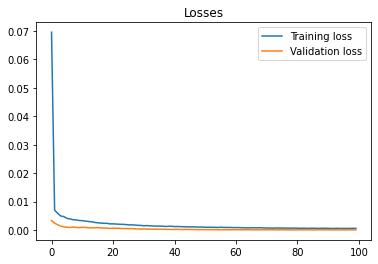

In [ ]:
input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 128
dropout = 0.2
n_epochs = 100
learning_rate = 1e-4
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = RNNModel(**model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

In [ ]:
def inverse_transform( scaler: sklearn.preprocessing._data.MinMaxScaler, df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    :param scaler: скейлер
    :param df: датафрейм
    :param columns: выбранные столбцы
    :return: возвращает полученный датафрейм
    """
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions: list, values: list, df_test: pd.DataFrame, scaler: sklearn.preprocessing._data.MinMaxScaler)-> pd.DataFrame:
    """
    фукнция создает датафрейм с прогнозами
    :param predictions: список с предсказанными значениями
    :param values: список с реальными значениями
    :param df_test: тестовая выборка
    :param scaler: скейлер
    :return: возвращает датафрейм с прогнозами
    """
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result


df_result = format_predictions(predictions, values, X_test, scaler)
df_result

,value,prediction
date,,
1998-06-20,26.736399,27.287970
1998-06-26,36.184704,36.621773
1998-07-04,29.153702,29.824121
1998-08-05,27.055401,27.413752
1998-09-01,30.840902,31.555262
...,...,...
2022-07-28,29.232500,29.812851
2022-08-24,29.028702,29.619530
2022-09-21,31.697701,32.423492


In [ ]:
def calculate_metrics(df: pd.DataFrame) -> dict:
    """
    функция считает метрики качества для прогноза
    :param df: датафрейм
    :return: возвращает метрики качества
    """
    result_metrics = {'mae' : mean_absolute_error(df.value, df.prediction),
                      'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
                      'r2' : r2_score(df.value, df.prediction)}
    
    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("R^2 Score:                 ", result_metrics["r2"])
    return result_metrics

result_metrics = calculate_metrics(df_result)

Mean Absolute Error:        0.80005467
Root Mean Squared Error:    1.2269301622750501
R^2 Score:                  0.9955580480211507


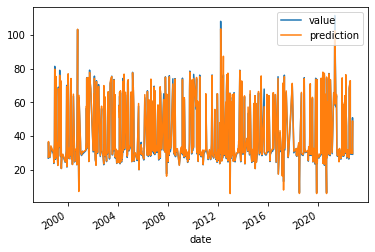

In [ ]:
df_result.plot()

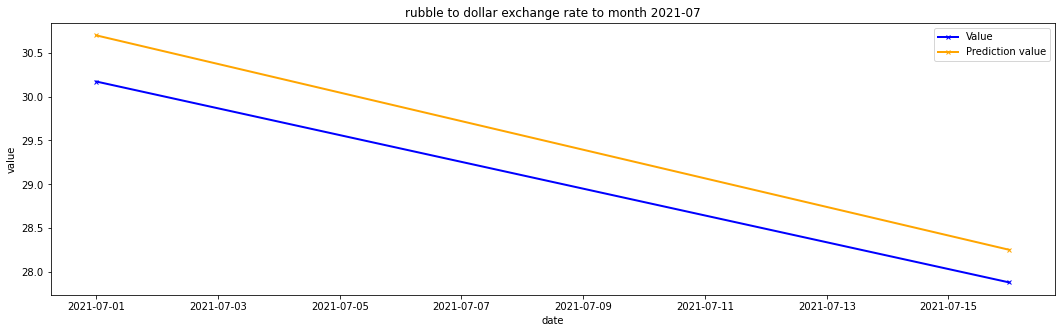

In [ ]:
def filter_dataframe_date(df: pd.DataFrame, date_start: pd.Timestamp, date_end: pd.Timestamp) -> pd.DataFrame:
    """
    функция возвращает отфильтрованный датафрейм, в котором находятся записи принадлежащий отрезку времени от
    date_start до date_end
    :param df: датафрейм
    :param date_start: начальная дата
    :param date_end: конечная дата
    :return: возвращает отфильтрованный датафрейм
    """
    df_copy = df.copy(deep=True)
    df_copy.reset_index(drop = False, inplace=True)
    return df_copy[(date_start <= df_copy.date) & (df_copy.date <= date_end)]


def comparison_for_month(df: pd.DataFrame, month: int, year: int) -> None:
    """
    функция рисует график за выбранный месяц
    :param df: датафрейм
    :param month: выбранный месяц
    :param year: выбранный год
    :return: ничего не возвращает
    """
    date_start = pd.Timestamp(year, month, 1)
    date_end = pd.Timestamp(year, month, date_start.days_in_month)
    df_filtered = filter_dataframe_date(df, date_start, date_end)
    df_filtered = df_filtered.set_index(['date'])
    plt.figure(figsize=(18, 5))
    plt.xlabel('date')
    plt.ylabel('value')
    plt.title(f'rubble to dollar exchange rate to month {year}-{month:02d}')
    plt.plot(df_filtered['value'], color="blue", marker="x", linewidth=2, markersize=4)
    plt.plot(df_filtered['prediction'], color="orange", marker="x", linewidth=2, markersize=4)
    plt.legend(["Value", "Prediction value"])
    plt.show()


month, year = 7, 2021
comparison_for_month(df_result, month, year)